# DIP Baseline

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchvision import models
from torch.nn.functional import relu

%matplotlib inline

In [2]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


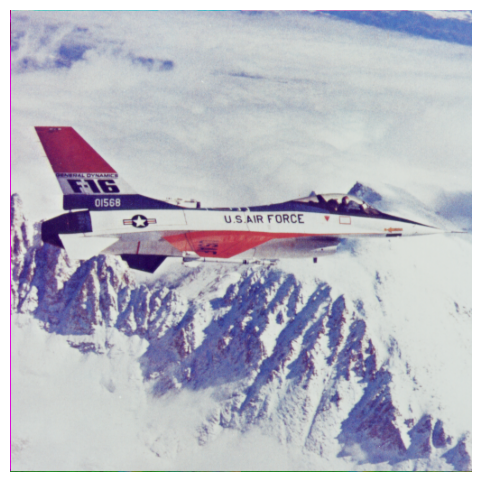

In [3]:
# read the original image
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(10,6))
axis1.imshow(img)
axis1.set_axis_off()

In [15]:
# define forward diffusion function for the DDPM stages
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    # Starting from step 100, I set it as Stage 1. Step 110 -> Stage 2, and so on
    output = np.array(x_t)[100::20]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

# parameters for forward diffusion
x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

In [42]:
# setup double convolution class
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# setup UNet class
class UNet(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(UNet, self).__init__()
        
        # Encoder
        self.downconv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.downconv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, output_channel, kernel_size=1)

    def forward(self, x):
        dc1 = self.downconv1(x)
        p1 = self.pool1(dc1)

        dc2 = self.downconv2(p1)
        p2 = self.pool2(dc2)

        dc3 = self.downconv3(p2)
        p3 = self.pool3(dc3)
        
        dc4 = self.downconv4(p3)
        p4 = self.pool4(dc4)
        
        dc5 = self.conv5(p4)
        
        uc6 = self.upconv1(dc5)
        concat6 = torch.cat([uc6, dc4], dim=1)
        c6 = self.conv6(concat6)
        
        uc7 = self.upconv2(c6)
        concat7 = torch.cat([uc7, dc3], dim=1)
        c7 = self.conv7(concat7)
        
        uc8 = self.upconv3(c7)
        concat8 = torch.cat([uc8, dc2], dim=1)
        c8 = self.conv8(concat8)
        
        uc9 = self.upconv4(c8)
        concat9 = torch.cat([uc9, dc1], dim=1)
        c9 = self.conv9(concat9)
        
        c10 = self.outconv(c9)
        #out = nn.Sigmoid()(c10)
        return c10
    
    
unet = UNet(3, 3).to(device)

Text(0.5, 1.0, 'input image 512 x 512')

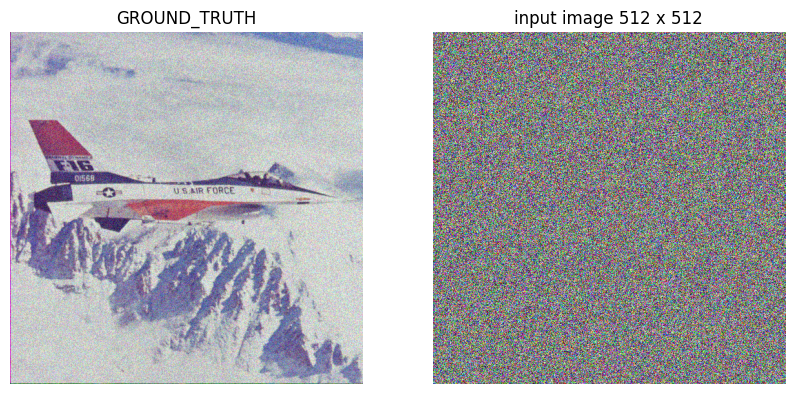

In [55]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

fig2, axis2 = plt.subplots(1, 2, figsize=(10,6))
# I set step 100 image as my ground truth
axis2[0].imshow(x_t[1])
axis2[0].set_title('GROUND_TRUTH')
axis2[0].set_axis_off()
axis2[1].set_axis_off()
axis2[1].imshow(torch_to_numpy(input_image))
axis2[1].set_title('input image %d x %d' %(nxd, nxd))

In [56]:
# initialize training valiables
optimiser = torch.optim.Adam(unet.parameters(), lr=1e-4)
train_loss = []
output_psnr = [] # records max psnr for each stage

print("Total stages:", len(x_t))

Total stages: 46


In [57]:
mse_fn = nn.MSELoss().to(device)
cnt = 0
best_psnr = 0
# training process
for ep in tqdm(range(1000)):
    optimiser.zero_grad()
    output_image = unet(input_image.unsqueeze(0).permute(0, 3, 1, 2))
    output_image = output_image.squeeze(0).permute(1, 2, 0)
    loss = mse_fn(numpy_to_torch(x_t[1]).to(device), output_image)

    train_loss.append(loss.item())
    loss.backward() # find gradients
    optimiser.step() # does the update

    psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
    
    if(psnr <= best_psnr):
        cnt += 1
    else:
        best_psnr = psnr
        cnt = 0
    
    if(cnt == 3):
        break
    
    if(ep % 50 == 0):
        print(loss.item())
        output_psnr.append(psnr)

  0%|          | 1/1000 [00:00<05:50,  2.85it/s]

0.0615990087389946


  5%|▌         | 51/1000 [00:14<04:30,  3.51it/s]

0.0013689290499314666


 10%|█         | 101/1000 [00:28<04:20,  3.46it/s]

0.00024785182904452085


 15%|█▌        | 151/1000 [00:43<04:02,  3.50it/s]

6.156227027531713e-05


 20%|█▉        | 199/1000 [00:57<03:49,  3.49it/s]


Text(0.5, 1.0, 'Output Image')

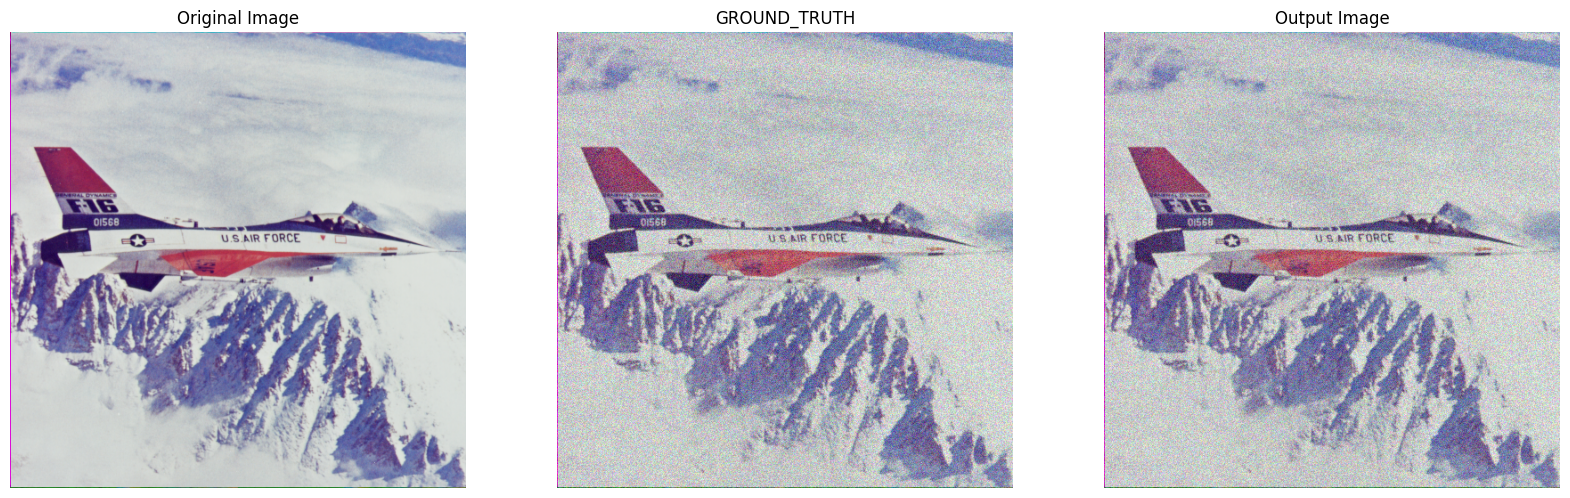

In [58]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[0].set_title('Original Image')
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[1].set_title('GROUND_TRUTH')
axis1[2].imshow(torch_to_numpy(output_image))
axis1[2].set_axis_off()
axis1[2].set_title('Output Image')

Text(0, 0.5, 'MSE')

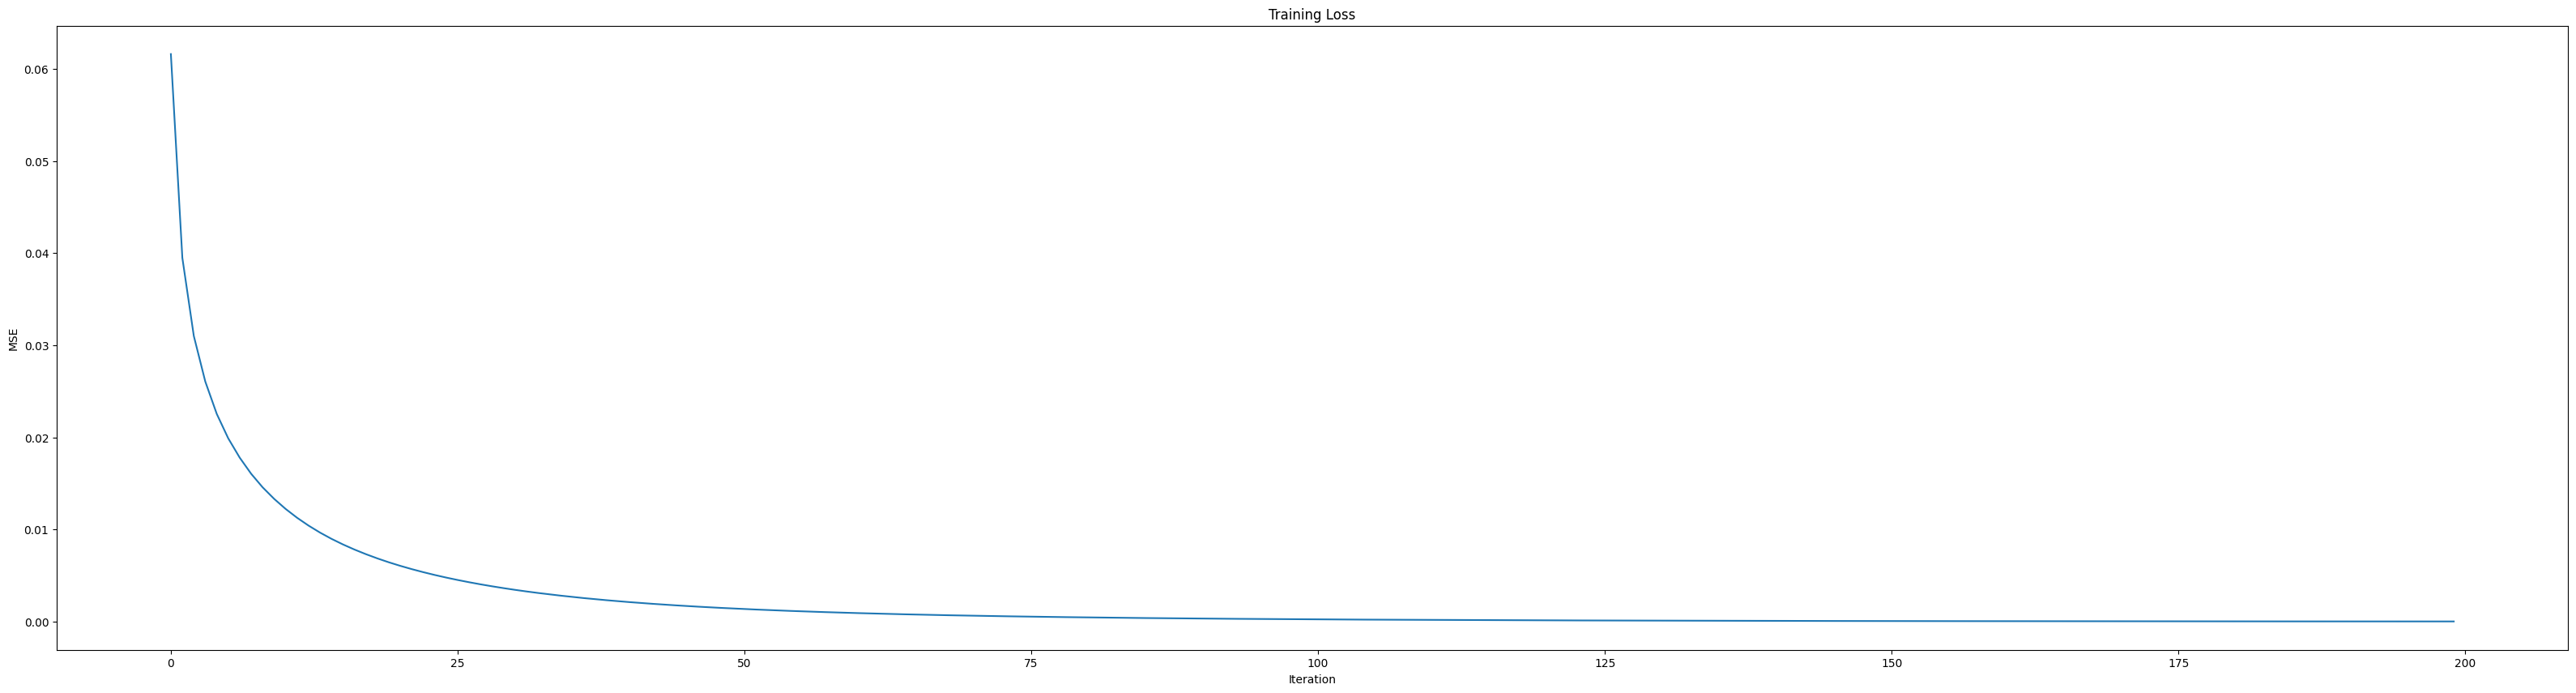

In [59]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)
axis1.set_title('Training Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE")

Text(0, 0.5, 'PSNR')

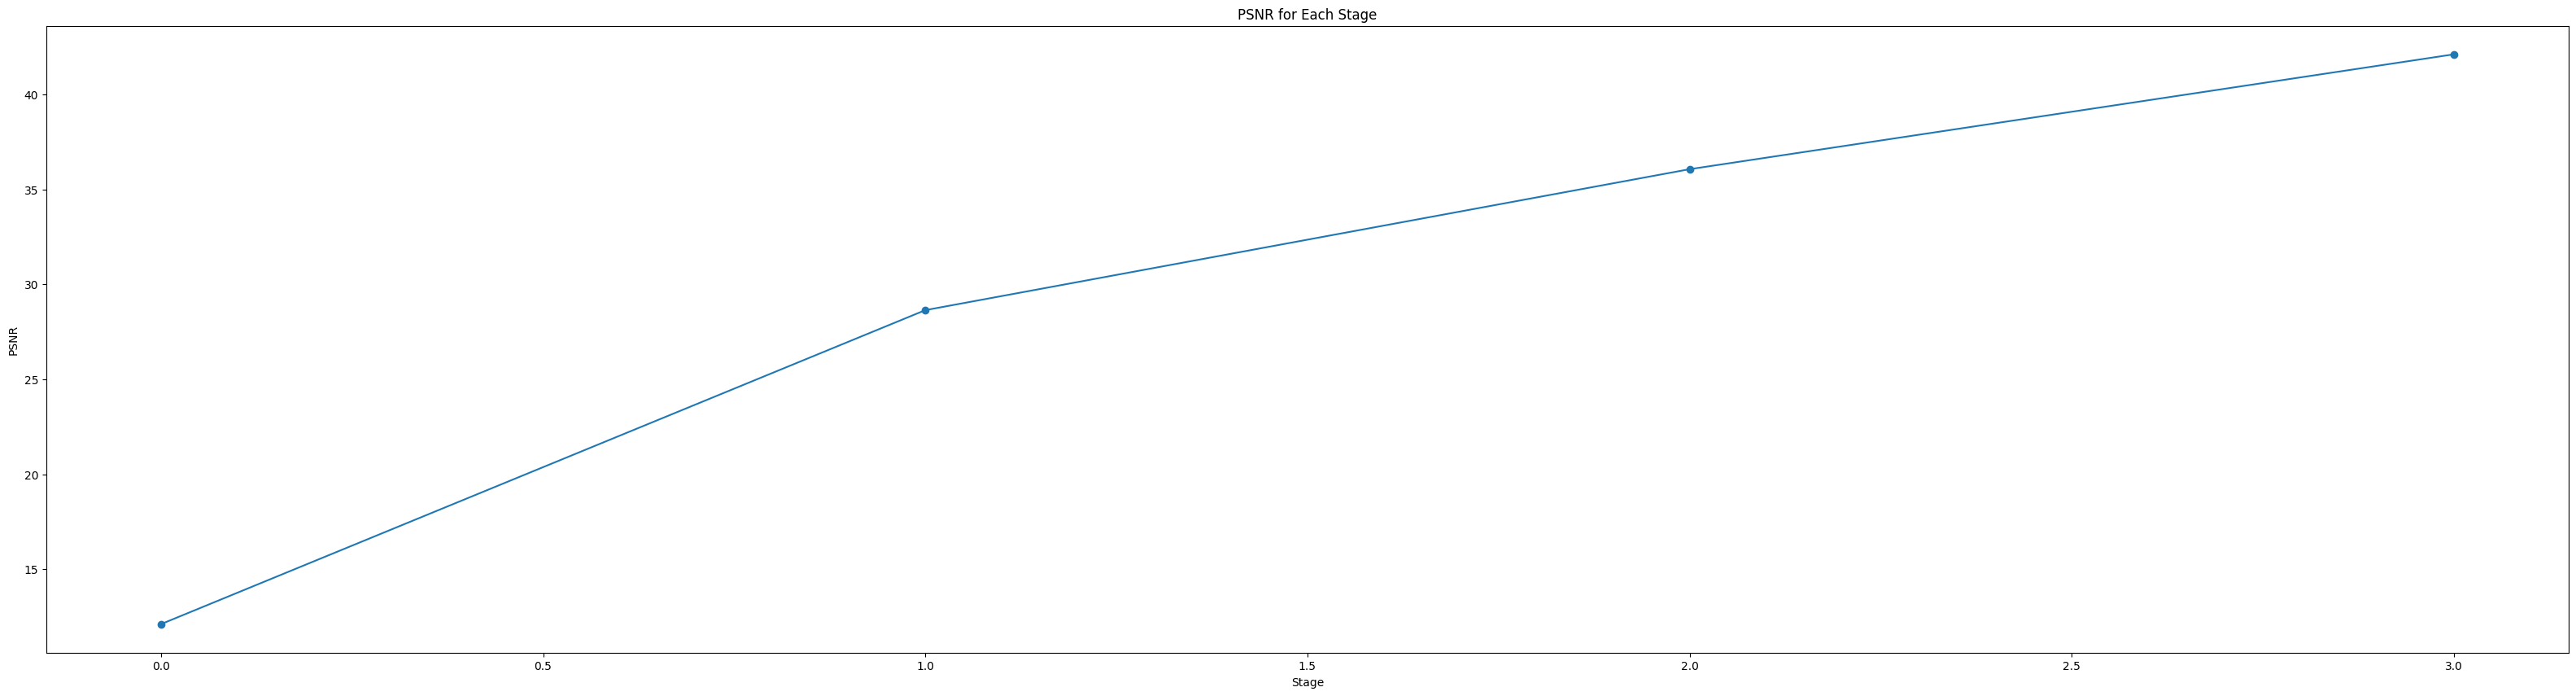

In [60]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(output_psnr, marker = 'o')
axis1.set_title('PSNR for Each Stage')
plt.xlabel("Stage")
plt.ylabel("PSNR")

In [62]:
# Calculate PSNR for output image and original image
original_img = (img - img.min()) / (img.max() - img.min())
compare_psnr(torch_to_numpy(output_image), original_img, data_range=original_img.max())

18.30681979572961